In [ ]:
!pip install pandas scipy scikit-learn cupy-cuda101 livelossplot==0.5.1

In [2]:
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split

from bprH_gpu import bprH

%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
data = pd.read_csv("Sobazaar-bprh-cleaned.csv")

In [4]:
# Here we only consider data with View
data = data[~(data.Action == "L")]
data.reset_index(inplace=True, drop=True)
data.drop_duplicates(inplace=True)

In [5]:
# we select user wo have purchased at least 1 items
user_filter = data[data.Action == "P"].groupby("UserID").count().ItemID
data_filtered = data[data.UserID.isin(user_filter[user_filter >= 1].index.tolist())]

In [6]:
data_without_target = data_filtered[data_filtered.Action != 'P']
data_only_with_target = data_filtered[data_filtered.Action == 'P']

In [7]:
d1, test_data = train_test_split(data_only_with_target,
                                 test_size=0.2,
                                 random_state=20200722
                                 )

train_data = pd.concat([d1, data_without_target])
train_data.reset_index(inplace=True,drop=True)
test_data.reset_index(inplace=True,drop=True)

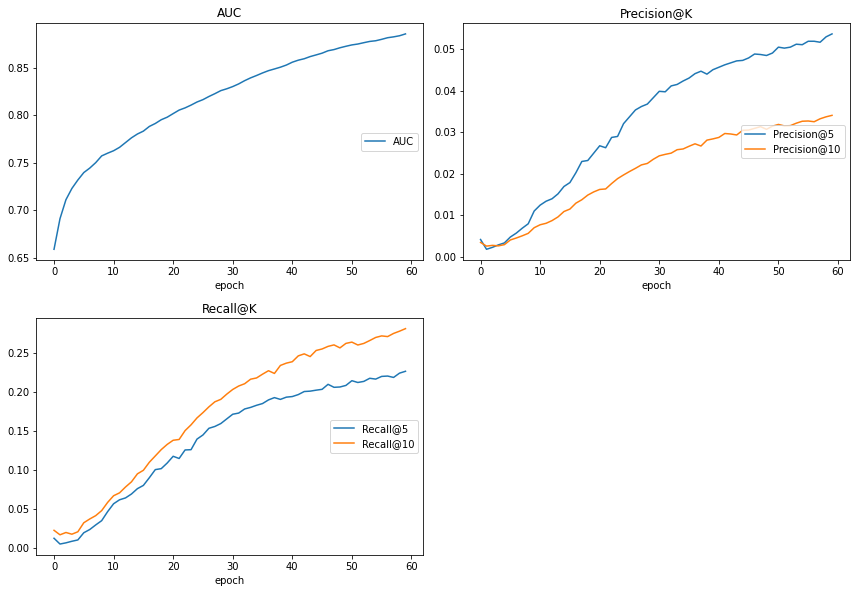

100%|██████████| 720000/720000 [6:35:48<00:00, 30.32it/s, est_changed=5.53811570559973, len_I=1, len_J=1, len_K=1]   

AUC
	AUC              	 (min:    0.659, max:    0.885, cur:    0.885)
Precision@K
	Precision@5      	 (min:    0.002, max:    0.054, cur:    0.054)
	Precision@10     	 (min:    0.003, max:    0.034, cur:    0.034)
Recall@K
	Recall@5         	 (min:    0.005, max:    0.227, cur:    0.227)
	Recall@10        	 (min:    0.017, max:    0.281, cur:    0.281)


In [8]:
bprh_model = bprH(dim=50,
                  omega=1000,
                  rho=1,
                  lambda_u=0.00001/2,
                  lambda_v=0.00001/2,
                  lambda_b=0.1/2,
                  gamma=0.1,
                  random_state=20200722,
                  num_iter=180000*4,
                  existed_model_path=None)

bprh_model.fit(X=train_data,
               eval_X=test_data,
               model_saved_path="/content/drive/My Drive/BPRH/bprh_soba_0718_filtered5.pkl",
               correlation=True,
               coselection=True,
               plot_metric=True,
               log_metric=True,
               iter_to_log=12000,
               iter_to_save=180000*8)

In [ ]:
scoring_list, p, r, auc = bprh_model.scoring(ground_truth=bprh_model.test_data,
                                      K=10,
                                      train_data_as_reference_flag=True)
print('Recall: test %.4f.' % r)
print('Precision: test %.4f.' % p)
print('AUC: test %.4f.' % auc)

In [ ]:
scoring_list, p, r, auc = bprh_model.scoring(ground_truth=bprh_model.train_data,
                                      K=10,
                                      train_data_as_reference_flag=False)
print('Recall: train %.4f.' % r)
print('Precision: train %.4f.' % p)
print('AUC: train %.4f.' % auc)